In [ ]:
!pip install geopandas
!pip install folium
!pip install lightgbm
!pip install utm
!pip install geojson 
!pip install haversine

In [ ]:
# 시각화 도구 설치
!pip install plotnine #R 시각화 
!pip install folium #지도 시각화 

# 그래프에서 한글표현을 위해 폰트를 설치합니다.
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [1]:
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [2]:
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np
import folium 
import geopandas as gpd
import math
from tqdm.notebook import tqdm
import utm
from shapely.geometry import Point, Polygon
from haversine import haversine
from plotnine import *

In [84]:
df_mia = pd.read_excel('/content/drive/My Drive/Project/Seoul/건축물대장_층별개요/층별개요_강북구_미아동.xlsx', header =4)
df_mia

,순번,대지위치,시군구코드,법정동코드,대지구분코드,번,지,관리건축물대장PK,도로명대지위치,건물명,특수지명,블록,로트,새주소도로코드,새주소법정동코드,새주소지상지하코드,새주소본번,새주소부번,동명칭,층구분코드,층구분코드명,층번호,층번호명,구조코드,구조코드명,기타구조,주용도코드,주용도코드명,기타용도,면적(㎡),주부속구분코드,주부속구분코드명,면적제외여부,생성일자
0,1,서울특별시 강북구 미아동 1-14번지,11305,10100,0,1,14,11305-738,서울특별시 강북구 오현로 72,NaN,NaN,NaN,NaN,1.130531e+11,10101.0,0,72.0,0.0,NaN,20.0,지상,1,1층,11.0,벽돌구조,연와조,01001,단독주택,주택,55.21,0.0,주건축물,NaN,20170425
1,2,서울특별시 강북구 미아동 1-14번지,11305,10100,0,1,14,11305-738,서울특별시 강북구 오현로 72,NaN,NaN,NaN,NaN,1.130531e+11,10101.0,0,72.0,0.0,NaN,10.0,지하,1,지층,11.0,벽돌구조,연와조,01001,단독주택,주택,8.89,0.0,주건축물,NaN,20170425
2,3,서울특별시 강북구 미아동 100-10번지,11305,10100,0,100,10,11305-2822,서울특별시 강북구 도봉로18길 14-13,NaN,NaN,NaN,NaN,1.130541e+11,10101.0,0,14.0,13.0,NaN,10.0,지하,1,지층,11.0,벽돌구조,연와조,01003,다가구주택,다가구용단독주택,58.32,0.0,주건축물,NaN,20170209
3,4,서울특별시 강북구 미아동 100-10번지,11305,10100,0,100,10,11305-2822,서울특별시 강북구 도봉로18길 14-13,NaN,NaN,NaN,NaN,1.130541e+11,10101.0,0,14.0,13.0,NaN,20.0,지상,1,1층,11.0,벽돌구조,연와조,01003,다가구주택,다가구용단독주택,51.72,0.0,주건축물,NaN,20170209
4,5,서울특별시 강북구 미아동 100-10번지,11305,10100,0,100,10,11305-2822,서울특별시 강북구 도봉로18길 14-13,NaN,NaN,NaN,NaN,1.130541e+11,10101.0,0,14.0,13.0,NaN,20.0,지상,2,2층,11.0,벽돌구조,연와조,01003,다가구주택,다가구용단독주택,51.72,0.0,주건축물,NaN,20170209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,서울특별시 강북구 미아동 98-4번지,11305,10100,0,98,4,11305-2803,서울특별시 강북구 도봉로 90,NaN,NaN,NaN,NaN,1.130530e+11,10101.0,0,90.0,NaN,NaN,20.0,지상,4,4층,21.0,철근콘크리트구조,철근콘크리트조,03999,기타제1종근린생활시설,근린생활시설,141.93,0.0,주건축물,NaN,20190904
39996,39997,서울특별시 강북구 미아동 98-4번지,11305,10100,0,98,4,11305-2803,서울특별시 강북구 도봉로 90,NaN,NaN,NaN,NaN,1.130530e+11,10101.0,0,90.0,NaN,NaN,20.0,지상,1,1층,21.0,철근콘크리트구조,철근콘크리트조,04001,일반음식점,제2종근린생황시설(일반음식점),165.06,0.0,주건축물,NaN,20190904
39997,39998,서울특별시 강북구 미아동 98-4번지,11305,10100,0,98,4,11305-2803,서울특별시 강북구 도봉로 90,NaN,NaN,NaN,NaN,1.130530e+11,10101.0,0,90.0,NaN,NaN,20.0,지상,4,4층,21.0,철근콘크리트구조,철근콘크리트조,04402,사무소,제2종근린생활시설(사무소),50.04,0.0,주건축물,0.0,20190904
39998,39999,서울특별시 강북구 미아동 98-9번지,11305,10100,0,98,9,11305-2804,서울특별시 강북구 도봉로18길 10-10,NaN,NaN,NaN,NaN,1.130541e+11,10101.0,0,10.0,10.0,NaN,20.0,지상,1,1층,11.0,벽돌구조,연와조,01001,단독주택,주택,41.45,0.0,주건축물,NaN,20170811


In [11]:
df_mia.columns

Index(['순번', '대지위치', '시군구코드', '법정동코드', '대지구분코드', '번', '지', '관리건축물대장PK',
       '도로명대지위치', '건물명', '특수지명', '블록', '로트', '새주소도로코드', '새주소법정동코드',
       '새주소지상지하코드', '새주소본번', '새주소부번', '동명칭', '층구분코드', '층구분코드명', '층번호', '층번호명',
       '구조코드', '구조코드명', '기타구조', '주용도코드', '주용도코드명', '기타용도', '면적(㎡)', '주부속구분코드',
       '주부속구분코드명', '면적제외여부', '생성일자', '법정동_코드'],
      dtype='object')

In [86]:
# 시군구코드 + 법정동 코드 => 법정동 코드 만들기 
df_mia['법정동_코드'] = df_mia[['시군구코드','법정동코드']].astype(str).agg(''.join, axis=1).astype(int)


In [87]:
df_mia =df_mia[['관리건축물대장PK','법정동_코드','대지위치', '도로명대지위치','주용도코드','주용도코드명','기타용도','층구분코드명','층번호명','층번호','면적(㎡)']]
df_mia

,관리건축물대장PK,법정동_코드,대지위치,도로명대지위치,주용도코드,주용도코드명,기타용도,층구분코드명,층번호명,층번호,면적(㎡)
0,11305-738,1130510100,서울특별시 강북구 미아동 1-14번지,서울특별시 강북구 오현로 72,01001,단독주택,주택,지상,1층,1,55.21
1,11305-738,1130510100,서울특별시 강북구 미아동 1-14번지,서울특별시 강북구 오현로 72,01001,단독주택,주택,지하,지층,1,8.89
2,11305-2822,1130510100,서울특별시 강북구 미아동 100-10번지,서울특별시 강북구 도봉로18길 14-13,01003,다가구주택,다가구용단독주택,지하,지층,1,58.32
3,11305-2822,1130510100,서울특별시 강북구 미아동 100-10번지,서울특별시 강북구 도봉로18길 14-13,01003,다가구주택,다가구용단독주택,지상,1층,1,51.72
4,11305-2822,1130510100,서울특별시 강북구 미아동 100-10번지,서울특별시 강북구 도봉로18길 14-13,01003,다가구주택,다가구용단독주택,지상,2층,2,51.72
...,...,...,...,...,...,...,...,...,...,...,...
39995,11305-2803,1130510100,서울특별시 강북구 미아동 98-4번지,서울특별시 강북구 도봉로 90,03999,기타제1종근린생활시설,근린생활시설,지상,4층,4,141.93
39996,11305-2803,1130510100,서울특별시 강북구 미아동 98-4번지,서울특별시 강북구 도봉로 90,04001,일반음식점,제2종근린생황시설(일반음식점),지상,1층,1,165.06
39997,11305-2803,1130510100,서울특별시 강북구 미아동 98-4번지,서울특별시 강북구 도봉로 90,04402,사무소,제2종근린생활시설(사무소),지상,4층,4,50.04
39998,11305-2804,1130510100,서울특별시 강북구 미아동 98-9번지,서울특별시 강북구 도봉로18길 10-10,01001,단독주택,주택,지상,1층,1,41.45


## 1. 주민공동시설
    - 기타용도: 주민공동시설 포함

In [88]:
# 기타용도 nan값 제거 
df_CMTY = df_mia.dropna(subset=['기타용도'])

# 주민공동시설 
mask = df_CMTY['기타용도'].str.contains('주민공동시설') 
CMTY_Facil = df_CMTY[mask].reset_index().drop(['index'], axis=1)
CMTY_Facil

,관리건축물대장PK,법정동_코드,대지위치,도로명대지위치,주용도코드,주용도코드명,기타용도,층구분코드명,층번호명,층번호,면적(㎡)
0,11305-100224212,1130510100,서울특별시 강북구 미아동 133-125번지,서울특별시 강북구 도봉로30길 43-30,02003,다세대주택,도시형생활주택(다세대주택_주민공동시설),지상,1층,1,7.350
1,11305-100234406,1130510100,서울특별시 강북구 미아동 133-19번지,서울특별시 강북구 도봉로30길 43-11,02003,다세대주택,공동주택[다세대주택-주민공동시설],지상,1층,1,7.590
2,11305-100225012,1130510100,서울특별시 강북구 미아동 162-4번지,서울특별시 강북구 도봉로78길 22,02003,다세대주택,주민공동시설,지상,1층,1,12.620
3,11305-100223372,1130510100,서울특별시 강북구 미아동 218-80번지,서울특별시 강북구 솔매로43길 87,03001,소매점,"제1종근린생활시설(소매점,주민공동시설)",지상,1층,1,46.410
4,11305-100229552,1130510100,서울특별시 강북구 미아동 307-51번지,서울특별시 강북구 도봉로49길 67,02003,다세대주택,도시형생활주택단지형다세대(주민공동시설),지상,1층,1,6.250
5,11305-100224913,1130510100,서울특별시 강북구 미아동 310-13번지,서울특별시 강북구 삼양로54길 134,02003,다세대주택,단지형다세대주택(주민공동시설),지상,1층,1,5.000
6,11305-100225772,1130510100,서울특별시 강북구 미아동 314-94번지,서울특별시 강북구 도봉로39길 51-6,02003,다세대주택,주민공동시설,지상,1층,1,9.040
7,11305-100185242,1130510100,서울특별시 강북구 미아동 318-5번지,서울특별시 강북구 도봉로33길 18,02001,아파트,공동주택(아파트:주민공동시설),지상,PIT층,1,97.060
8,11305-100223913,1130510100,서울특별시 강북구 미아동 325-5번지,서울특별시 강북구 도봉로23나길 20,02003,다세대주택,계단실 및 주민공동시설,지상,1층,1,25.000
9,11305-100231884,1130510100,서울특별시 강북구 미아동 326-25번지,서울특별시 강북구 도봉로27길 19-4,02003,다세대주택,주민공동시설,지상,1층,1,5.040


## 3. 노유자시설
    - 기타용도: 노유자 시설 포함

In [89]:
# 기타용도 nan값 제거 
df_noyu = df_mia.dropna(subset=['기타용도'])

# 주민공동시설 
mask = df_noyu['기타용도'].str.contains('노유자') 
Elderly_Child = df_noyu[mask].reset_index().drop(['index'], axis=1)
Elderly_Child

,관리건축물대장PK,법정동_코드,대지위치,도로명대지위치,주용도코드,주용도코드명,기타용도,층구분코드명,층번호명,층번호,면적(㎡)
0,11305-3119,1130510100,서울특별시 강북구 미아동 127-16번지,서울특별시 강북구 솔매로50길 69-7,11102,영유아보육시설,노유자시설(영유아보육시설),지상,2층,2,101.98
1,11305-3119,1130510100,서울특별시 강북구 미아동 127-16번지,서울특별시 강북구 솔매로50길 69-7,11102,영유아보육시설,노유자시설(영유아보육시설),지상,1층,1,88.89
2,11305-3206,1130510100,서울특별시 강북구 미아동 130-2번지,서울특별시 강북구 도봉로34길 43-13,11199,기타아동관련시설,노유자시설(기타아동관련시설),지상,2층,2,79.20
3,11305-3206,1130510100,서울특별시 강북구 미아동 130-2번지,서울특별시 강북구 도봉로34길 43-13,11199,기타아동관련시설,노유자시설(기타아동관련시설),지하,지층,1,11.07
4,11305-3206,1130510100,서울특별시 강북구 미아동 130-2번지,서울특별시 강북구 도봉로34길 43-13,11199,기타아동관련시설,노유자시설(기타아동관련시설),지상,1층,1,82.65
...,...,...,...,...,...,...,...,...,...,...,...
76,11305-2594,1130510100,서울특별시 강북구 미아동 84-20번지,서울특별시 강북구 오패산로38길 6-15,11103,어린이집,노유자시설(어린이집),지상,3층,3,70.64
77,11305-2594,1130510100,서울특별시 강북구 미아동 84-20번지,서울특별시 강북구 오패산로38길 6-15,11103,어린이집,노유자시설(어린이집),지상,1층,1,67.68
78,11305-2689,1130510100,서울특별시 강북구 미아동 87-141번지,서울특별시 강북구 오패산로 162,11103,어린이집,노유자시설(어린이집),지상,2층,2,260.96
79,11305-2661,1130510100,서울특별시 강북구 미아동 87-54번지,서울특별시 강북구 오현로 32,11201,노인복지시설,노유자시설(노인복지시설),지상,3층,3,306.00


## 4. 사회복지시설
    - 기타용도: '복지' 포함 시설 중 '학교', '사무실' 등 제외

In [90]:
# 기타용도 nan값 제거 
df_welfare = df_mia.dropna(subset=['기타용도'])

# 주민공동시설 
mask1 = df_welfare['기타용도'].str.contains('복지') 
mask2 = df_welfare['기타용도'].str.contains('학교') 
mask3 = df_welfare['기타용도'].str.contains('사무실')
mask4 = df_welfare['기타용도'].str.contains('학원')

Welfare = df_welfare[mask1 & ~mask2 & ~mask3 & ~mask4].reset_index().drop(['index'], axis=1)

Welfare

,관리건축물대장PK,법정동_코드,대지위치,도로명대지위치,주용도코드,주용도코드명,기타용도,층구분코드명,층번호명,층번호,면적(㎡)
0,11305-3094,1130510100,서울특별시 강북구 미아동 126-31번지,서울특별시 강북구 도봉로 164,11199,기타아동관련시설,교육연구및복지시설(아동관련시설),지상,2층,2,178.12
1,11305-3094,1130510100,서울특별시 강북구 미아동 126-31번지,서울특별시 강북구 도봉로 164,11199,기타아동관련시설,교육연구및복지시설(아동관련시설),지상,3층,3,178.12
2,11305-3143,1130510100,서울특별시 강북구 미아동 128-55번지,서울특별시 강북구 도봉로18길 148,11104,아동복지시설,교육연구및복지시설,지상,2층,2,51.53
3,11305-3143,1130510100,서울특별시 강북구 미아동 128-55번지,서울특별시 강북구 도봉로18길 148,11104,아동복지시설,교육연구및복지시설,지상,1층,1,61.98
4,11305-3283,1130510100,서울특별시 강북구 미아동 131-6번지,서울특별시 강북구 도봉로 144,11201,노인복지시설,노인복지시설,지상,3층,3,441.90
...,...,...,...,...,...,...,...,...,...,...,...
88,11305-1377,1130510100,서울특별시 강북구 미아동 8-65번지,서울특별시 강북구 월계로21가길 42-1,11199,기타아동관련시설,교육연구및복지시설(아동관련시설),지상,1층,1,75.53
89,11305-2705,1130510100,서울특별시 강북구 미아동 87-179번지,서울특별시 강북구 오패산로 156-3,10999,기타교육연구시설,교육연구및복지시설,지상,1층,1,118.38
90,11305-2705,1130510100,서울특별시 강북구 미아동 87-179번지,서울특별시 강북구 오패산로 156-3,10999,기타교육연구시설,교육연구및복지시설,지상,2층,2,68.45
91,11305-2661,1130510100,서울특별시 강북구 미아동 87-54번지,서울특별시 강북구 오현로 32,11201,노인복지시설,노유자시설(노인복지시설),지상,3층,3,306.00


## 6. 주민센터
    - 주용도코드: 자치단체 청사(14102)
    - 기타코드: 공공업무시설

In [91]:
# 기타용도 nan값 제거 
df_center = df_mia.dropna(subset=['기타용도'])

# 주민공동시설 
# 조건 2개 모두 결과 동일 => 하나만 쓰기 
mask1 = df_center['기타용도'].str.contains('공공업무시설') 
mask2 = df_center['주용도코드명'].str.contains('자치단체청사') 

CMTY_Center = df_center[mask2].reset_index().drop(['index'], axis=1)

CMTY_Center

,관리건축물대장PK,법정동_코드,대지위치,도로명대지위치,주용도코드,주용도코드명,기타용도,층구분코드명,층번호명,층번호,면적(㎡)
0,11305-100202718,1130510100,서울특별시 강북구 미아동 197-1번지,서울특별시 강북구 솔매로49길 14,14102,자치단체청사,공공업무시설(공공도서관),지상,5층,5,751.36
1,11305-100202718,1130510100,서울특별시 강북구 미아동 197-1번지,서울특별시 강북구 솔매로49길 14,14102,자치단체청사,"공공업무시설(주차장,기계실,전기실,발전기실)",지하,지하2층,2,1320.09
2,11305-100202718,1130510100,서울특별시 강북구 미아동 197-1번지,서울특별시 강북구 솔매로49길 14,14102,자치단체청사,"공공업무시설(주차장,창고,식당,통합관제센터)",지하,지하1층,1,1392.62
3,11305-100202718,1130510100,서울특별시 강북구 미아동 197-1번지,서울특별시 강북구 솔매로49길 14,14102,자치단체청사,공공업무시설,지상,4층,4,677.80
4,11305-100202718,1130510100,서울특별시 강북구 미아동 197-1번지,서울특별시 강북구 솔매로49길 14,14102,자치단체청사,공공업무시설,지상,3층,3,657.00
5,11305-100202718,1130510100,서울특별시 강북구 미아동 197-1번지,서울특별시 강북구 솔매로49길 14,14102,자치단체청사,"공공업무시설(강당,강습실,체력단련장,문고)",지상,2층,2,755.95
6,11305-100202718,1130510100,서울특별시 강북구 미아동 197-1번지,서울특별시 강북구 솔매로49길 14,14102,자치단체청사,공공업무시설,지상,1층,1,832.84


## 7. 마을회관
    - 주용도코드: 마을회관(03021)
    - 기타코드: 마을회관 포함

In [92]:
# 기타용도 nan값 제거 
df_maeul = df_mia.dropna(subset=['기타용도'])

# 마을회관
# 조건 2개 모두 결과 동일 => 하나만 쓰기 
mask1 = df_maeul['기타용도'].str.contains('마을회관') 
mask2 = df_maeul['주용도코드명'].str.contains('마을회관') 

Maeul = df_maeul[mask2].reset_index().drop(['index'], axis=1)

Maeul

,관리건축물대장PK,법정동_코드,대지위치,도로명대지위치,주용도코드,주용도코드명,기타용도,층구분코드명,층번호명,층번호,면적(㎡)
0,11305-3739,1130510100,서울특별시 강북구 미아동 138-11번지,서울특별시 강북구 도봉로20나길 6,03021,마을회관,제1종근린생활시설(마을회관),지상,3층,3,162.65
1,11305-100226600,1130510100,서울특별시 강북구 미아동 776-18번지,서울특별시 강북구 삼양로51길 22,03021,마을회관,마을회관,지하,지1,1,62.69
2,11305-100226600,1130510100,서울특별시 강북구 미아동 776-18번지,서울특별시 강북구 삼양로51길 22,03021,마을회관,마을회관,지상,1층,1,40.57
3,11305-100226600,1130510100,서울특별시 강북구 미아동 776-18번지,서울특별시 강북구 삼양로51길 22,03021,마을회관,마을회관,옥탑,옥탑층,0,13.18
4,11305-100226600,1130510100,서울특별시 강북구 미아동 776-18번지,서울특별시 강북구 삼양로51길 22,03021,마을회관,마을회관,지상,2층,2,49.69


## 8. 교육연구시설:초등학교제외
    - 기타용도: 교육연구 포함 → 학원 제외

In [93]:
# 기타용도 nan값 제거 
df_edu = df_mia.dropna(subset=['기타용도'])

mask1 = df_edu['기타용도'].str.contains('교육연구') 
mask2 = df_edu['기타용도'].str.contains('학원') 
mask3 = df_edu['기타용도'].str.contains('교사동') 

Edu = df_edu[mask1 & ~mask2 & ~mask3].reset_index().drop(['index'], axis=1)

Edu

,관리건축물대장PK,법정동_코드,대지위치,도로명대지위치,주용도코드,주용도코드명,기타용도,층구분코드명,층번호명,층번호,면적(㎡)
0,11305-100213256,1130510100,서울특별시 강북구 미아동 124-2번지,서울특별시 강북구 솔매로52길 31,10999,기타교육연구시설,교육연구시설,지하,지층,1,126.57
1,11305-100213256,1130510100,서울특별시 강북구 미아동 124-2번지,서울특별시 강북구 솔매로52길 31,10999,기타교육연구시설,교육연구시설,지상,3층,3,270.33
2,11305-100213256,1130510100,서울특별시 강북구 미아동 124-2번지,서울특별시 강북구 솔매로52길 31,10999,기타교육연구시설,교육연구시설,지상,2층,2,314.58
3,11305-100213256,1130510100,서울특별시 강북구 미아동 124-2번지,서울특별시 강북구 솔매로52길 31,10999,기타교육연구시설,교육연구시설,지상,1층,1,304.66
4,11305-3094,1130510100,서울특별시 강북구 미아동 126-31번지,서울특별시 강북구 도봉로 164,11199,기타아동관련시설,교육연구및복지시설(아동관련시설),지상,2층,2,178.12
...,...,...,...,...,...,...,...,...,...,...,...
195,11305-1353,1130510100,서울특별시 강북구 미아동 8-6번지,서울특별시 강북구 월계로 61,10102,중학교,교육연구시설(교사),지상,4층,4,561.36
196,11305-1353,1130510100,서울특별시 강북구 미아동 8-6번지,서울특별시 강북구 월계로 61,10102,중학교,교육연구시설(교사),지상,3층,3,546.29
197,11305-100201601,1130510100,서울특별시 강북구 미아동 812-4번지,서울특별시 강북구 삼양로19길 40,10103,고등학교,"교육연구시설(전기실,기계실)",지하,지하1층,1,522.94
198,11305-2705,1130510100,서울특별시 강북구 미아동 87-179번지,서울특별시 강북구 오패산로 156-3,10999,기타교육연구시설,교육연구및복지시설,지상,1층,1,118.38


# Merge

In [94]:
df_merge = pd.concat([CMTY_Facil, Elderly_Child, Welfare, CMTY_Center, Maeul, Edu], axis=0)
df_merge

,관리건축물대장PK,법정동_코드,대지위치,도로명대지위치,주용도코드,주용도코드명,기타용도,층구분코드명,층번호명,층번호,면적(㎡)
0,11305-100224212,1130510100,서울특별시 강북구 미아동 133-125번지,서울특별시 강북구 도봉로30길 43-30,02003,다세대주택,도시형생활주택(다세대주택_주민공동시설),지상,1층,1,7.35
1,11305-100234406,1130510100,서울특별시 강북구 미아동 133-19번지,서울특별시 강북구 도봉로30길 43-11,02003,다세대주택,공동주택[다세대주택-주민공동시설],지상,1층,1,7.59
2,11305-100225012,1130510100,서울특별시 강북구 미아동 162-4번지,서울특별시 강북구 도봉로78길 22,02003,다세대주택,주민공동시설,지상,1층,1,12.62
3,11305-100223372,1130510100,서울특별시 강북구 미아동 218-80번지,서울특별시 강북구 솔매로43길 87,03001,소매점,"제1종근린생활시설(소매점,주민공동시설)",지상,1층,1,46.41
4,11305-100229552,1130510100,서울특별시 강북구 미아동 307-51번지,서울특별시 강북구 도봉로49길 67,02003,다세대주택,도시형생활주택단지형다세대(주민공동시설),지상,1층,1,6.25
...,...,...,...,...,...,...,...,...,...,...,...
195,11305-1353,1130510100,서울특별시 강북구 미아동 8-6번지,서울특별시 강북구 월계로 61,10102,중학교,교육연구시설(교사),지상,4층,4,561.36
196,11305-1353,1130510100,서울특별시 강북구 미아동 8-6번지,서울특별시 강북구 월계로 61,10102,중학교,교육연구시설(교사),지상,3층,3,546.29
197,11305-100201601,1130510100,서울특별시 강북구 미아동 812-4번지,서울특별시 강북구 삼양로19길 40,10103,고등학교,"교육연구시설(전기실,기계실)",지하,지하1층,1,522.94
198,11305-2705,1130510100,서울특별시 강북구 미아동 87-179번지,서울특별시 강북구 오패산로 156-3,10999,기타교육연구시설,교육연구및복지시설,지상,1층,1,118.38


**기준1. 면적**
- 66 m^2 이상
- ['면적'] > 66   

    따라서 단순하게 생각하면 건축물 대장에 나와 있는 면적이 전유부분 공유부분으로 나와 있는 경우에는 전용면적과 공유(공용)면적을 구분할 수 있지만, 전유부분과 공유부분의 표시가 되어 있지 않을 경우에는 전용면적으로 생각하면 됩니다.
    http://blog.daum.net/ppssj/11315551

**기준2. 층수**
- 지하X, 5층 이상X

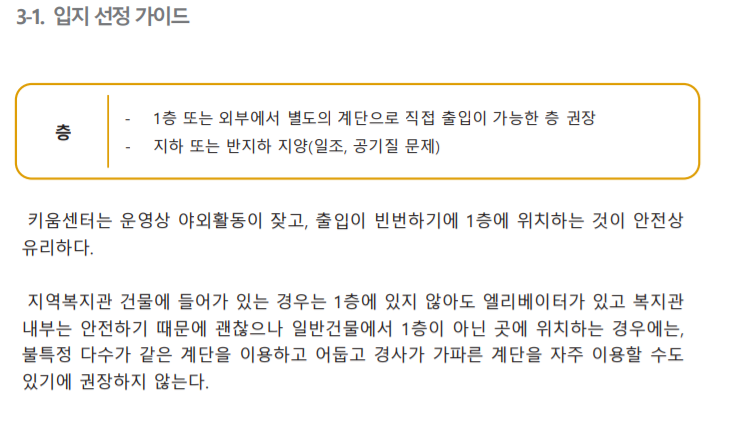

In [95]:
df_merge['층번호'].unique()

array([ 1,  2,  3,  4,  5,  6,  0,  7,  8, 10,  9])

In [96]:
df_merge['층번호명'].unique()

array(['1층', 'PIT층', '지1층', '지2층', '지하1층', '2층', '지층', '3층', '4층', '5층',
       '지1', '6층', '옥탑층', '지하2층', '7층', '8층', '10층', '9층'], dtype=object)

In [104]:
# 지층은 반지하래요.. 
df_merge[df_merge['층번호명'] == '지층']

,관리건축물대장PK,법정동_코드,대지위치,도로명대지위치,주용도코드,주용도코드명,기타용도,층구분코드명,층번호명,층번호,면적(㎡)
3,11305-3206,1130510100,서울특별시 강북구 미아동 130-2번지,서울특별시 강북구 도봉로34길 43-13,11199,기타아동관련시설,노유자시설(기타아동관련시설),지하,지층,1,11.07
66,11305-11009,1130510100,서울특별시 강북구 미아동 791-2119번지,서울특별시 강북구 삼양로41길 60,11199,기타아동관련시설,노유자시설(유아원),지하,지층,1,208.53
7,11305-3369,1130510100,서울특별시 강북구 미아동 133-7번지,서울특별시 강북구 도봉로30길 53,11201,노인복지시설,노인복지시설,지하,지층,1,125.52
13,11305-4242,1130510100,서울특별시 강북구 미아동 187-14번지,서울특별시 강북구 도봉로72길 14-4,11201,노인복지시설,노인복지시설(경로당),지하,지층,1,53.73
0,11305-100213256,1130510100,서울특별시 강북구 미아동 124-2번지,서울특별시 강북구 솔매로52길 31,10999,기타교육연구시설,교육연구시설,지하,지층,1,126.57
109,11305-6420,1130510100,서울특별시 강북구 미아동 320-1번지,서울특별시 강북구 도봉로29길 52,10199,기타학교,교육연구 및 복지시설(학교),지하,지층,1,100.76


In [106]:
# 면적 nan값 제거 
df_merge = pd.concat([CMTY_Facil, Elderly_Child, Welfare, CMTY_Center, Maeul, Edu], axis=0).dropna(subset=['면적(㎡)'])

mask1 = df_merge['면적(㎡)'] >= 66
mask2 = df_merge['층구분코드명'].str.contains('지상') 
mask3 = df_merge['층번호'] == 1
mask4 = df_merge['층번호명'].str.contains('PIT층') 

df = df_merge[mask1&mask2&mask3&~mask4].reset_index().drop(['index'], axis=1)
df

,관리건축물대장PK,법정동_코드,대지위치,도로명대지위치,주용도코드,주용도코드명,기타용도,층구분코드명,층번호명,층번호,면적(㎡)
0,11305-13876,1130510100,서울특별시 강북구 미아동 474번지,서울특별시 강북구 숭인로7가길 37,02005,부대시설,"노인정,주민공동시설",지상,1층,1,212.60
1,11305-14275,1130510100,서울특별시 강북구 미아동 797-8번지,서울특별시 강북구 삼양로 246-14,02001,아파트,"관리실,경비실,주민공동시설,MDF실,방재센터",지상,1층,1,104.05
2,11305-100204562,1130510100,서울특별시 강북구 미아동 811번지,서울특별시 강북구 삼양로27길 80,02001,아파트,"주민공동시설,문고",지상,1층,1,95.01
3,11305-3119,1130510100,서울특별시 강북구 미아동 127-16번지,서울특별시 강북구 솔매로50길 69-7,11102,영유아보육시설,노유자시설(영유아보육시설),지상,1층,1,88.89
4,11305-3206,1130510100,서울특별시 강북구 미아동 130-2번지,서울특별시 강북구 도봉로34길 43-13,11199,기타아동관련시설,노유자시설(기타아동관련시설),지상,1층,1,82.65
...,...,...,...,...,...,...,...,...,...,...,...
78,11305-1356,1130510100,서울특별시 강북구 미아동 8-6번지,서울특별시 강북구 월계로 61,10103,고등학교,교육연구시설(교사),지상,1층,1,703.80
79,11305-100193609,1130510100,서울특별시 강북구 미아동 8-6번지,서울특별시 강북구 월계로 61,10103,고등학교,교육연구시설(식당),지상,1층,1,1167.96
80,11305-1355,1130510100,서울특별시 강북구 미아동 8-6번지,서울특별시 강북구 월계로 61,10103,고등학교,교육연구시설(예절관),지상,1층,1,165.00
81,11305-1353,1130510100,서울특별시 강북구 미아동 8-6번지,서울특별시 강북구 월계로 61,10102,중학교,교육연구시설(교사),지상,1층,1,533.32


In [101]:
df_merge[mask1&mask2&mask3&~mask4].reset_index().drop(['index'], axis=1)['층번호명'].unique()

array(['1층'], dtype=object)

## 부가적인 필터링

In [107]:
df['주용도코드명'].unique()

array(['부대시설', '아파트', '영유아보육시설', '기타아동관련시설', '어린이집', '사회복지시설', '기타노유자시설',
       '기타교육연구시설', '노인복지시설', '아동복지시설', '기타학교', '자치단체청사', '초등학교', '대학교',
       '고등학교', '유치원', '중학교'], dtype=object)

In [109]:
df['기타용도'].unique()

array(['노인정,주민공동시설', '관리실,경비실,주민공동시설,MDF실,방재센터', '주민공동시설,문고',
       '노유자시설(영유아보육시설)', '노유자시설(기타아동관련시설)', '노유자시설(어린이집)',
       '노유자시설(심리상담센터)', '노유자시설', '노유자시설(아동관련시설)', '노유자시설(문화강좌실,사무실,상담실)',
       '노유자시설(유아원)', '아동복지시설', '교육연구및복지시설:', '노인복지시설(경로당)',
       '교육연구및 복지시설(아동관련시설)', '교육연구및복지시설(어린이집)', '교육연구및복지시설(아동관련시설)',
       '교육연구 및 복지시설(화장실)', '교육연구 및 복지시설(기숙사)', '교육연구및복지시설(영유아보육시설)',
       '교육연구및복지시설(교육연구및복지시설)', '교육연구및복지시설', '교육연구및복지시설(노인복지시설)',
       '교육연구및 복지시설', '영유아복지시설', '교육연구및복지시설(기타아동관련시설)', '공공업무시설', '교육연구시설',
       '교육연구시설(폐기물창고)', '교육연구시설(강의실)', '교육연구시설(컴퓨터실)', '교육연구시설(대학교)',
       '교육연구 및 복지시설(학교)', '교육연구시설(실습실,기계실,교사실)', '교육연구시설(3동)',
       '교육연구시설(2동)', '교육연구시설 (1동)', '교육연구시설(홀, 창고)', '교육연구시설(유치원)',
       '교육연구시설(급식실)', '교육연구시설(교사)', '교육연구시설(식당)', '교육연구시설(예절관)'],
      dtype=object)

1. 학교 뺴야할듯 (대학교는 애매하긴 하지만..)
2. 화장실, 기숙사, 컴퓨터실, 창고, 교사포함, 식당, 급식실, 경비실

In [112]:
# 면적 nan값 제거 
df_total = df.copy()

mask1 = df_total['주용도코드명'].str.contains('학교') 
mask2 = df_total['기타용도'].str.contains('화장실') 
mask3 = df_total['기타용도'].str.contains('기숙사') 
mask4 = df_total['기타용도'].str.contains('컴퓨터') 
mask5 = df_total['기타용도'].str.contains('창고') 
mask6 = df_total['기타용도'].str.contains('교사') 
mask7 = df_total['기타용도'].str.contains('식당') 
mask8 = df_total['기타용도'].str.contains('급식실') 
mask9 = df_total['기타용도'].str.contains('경비') 

total = df_total[~mask1&~mask2&~mask3&~mask4&~mask5&~mask6&~mask7&~mask8&~mask9].reset_index().drop(['index'], axis=1)
total

,관리건축물대장PK,법정동_코드,대지위치,도로명대지위치,주용도코드,주용도코드명,기타용도,층구분코드명,층번호명,층번호,면적(㎡)
0,11305-13876,1130510100,서울특별시 강북구 미아동 474번지,서울특별시 강북구 숭인로7가길 37,02005,부대시설,"노인정,주민공동시설",지상,1층,1,212.60
1,11305-100204562,1130510100,서울특별시 강북구 미아동 811번지,서울특별시 강북구 삼양로27길 80,02001,아파트,"주민공동시설,문고",지상,1층,1,95.01
2,11305-3119,1130510100,서울특별시 강북구 미아동 127-16번지,서울특별시 강북구 솔매로50길 69-7,11102,영유아보육시설,노유자시설(영유아보육시설),지상,1층,1,88.89
3,11305-3206,1130510100,서울특별시 강북구 미아동 130-2번지,서울특별시 강북구 도봉로34길 43-13,11199,기타아동관련시설,노유자시설(기타아동관련시설),지상,1층,1,82.65
4,11305-3719,1130510100,서울특별시 강북구 미아동 137-80번지,서울특별시 강북구 도봉로22길 7,11103,어린이집,노유자시설(어린이집),지상,1층,1,80.99
5,11305-100193148,1130510100,서울특별시 강북구 미아동 158-73번지,서울특별시 강북구 도봉로76길 33,11103,어린이집,노유자시설(어린이집),지상,1층,1,148.93
6,11305-100218958,1130510100,서울특별시 강북구 미아동 192-3번지,서울특별시 강북구 도봉로66길 35,11202,사회복지시설,노유자시설(심리상담센터),지상,1층,1,411.42
7,11305-100202821,1130510100,서울특별시 강북구 미아동 198-54번지,서울특별시 강북구 오패산로 290,11999,기타노유자시설,노유자시설,지상,1층,1,743.36
8,11305-758,1130510100,서울특별시 강북구 미아동 3-8번지,서울특별시 강북구 오현로9길 27,11199,기타아동관련시설,노유자시설(아동관련시설),지상,1층,1,122.63
9,11305-100222189,1130510100,서울특별시 강북구 미아동 321-12번지,서울특별시 강북구 도봉로31길 28,11103,어린이집,노유자시설(어린이집),지상,1층,1,130.72


In [131]:
# 같은 건물이라면 면적이 가장 큰 것만 남도록 
total = total.sort_values(by='면적(㎡)', ascending=False).drop_duplicates(subset='관리건축물대장PK').reset_index().drop('index', axis=1)
total

,관리건축물대장PK,법정동_코드,대지위치,도로명대지위치,주용도코드,주용도코드명,기타용도,층구분코드명,층번호명,층번호,면적(㎡)
0,11305-100202718,1130510100,서울특별시 강북구 미아동 197-1번지,서울특별시 강북구 솔매로49길 14,14102,자치단체청사,공공업무시설,지상,1층,1,832.84
1,11305-100189389,1130510100,서울특별시 강북구 미아동 812-1번지,서울특별시 강북구 삼양로27길 35,11102,영유아보육시설,노유자시설(영유아보육시설),지상,1층,1,760.88
2,11305-100202821,1130510100,서울특별시 강북구 미아동 198-54번지,서울특별시 강북구 오패산로 290,11999,기타노유자시설,노유자시설,지상,1층,1,743.36
3,11305-5498,1130510100,서울특별시 강북구 미아동 301-10번지,서울특별시 강북구 도봉로49길 62,11103,어린이집,교육연구및복지시설(어린이집),지상,1층,1,509.98
4,11305-100192699,1130510100,서울특별시 강북구 미아동 749-25번지,서울특별시 강북구 삼양로47길 9,11999,기타노유자시설,"노유자시설(문화강좌실,사무실,상담실)",지상,1층,1,443.89
5,11305-100218958,1130510100,서울특별시 강북구 미아동 192-3번지,서울특별시 강북구 도봉로66길 35,11202,사회복지시설,노유자시설(심리상담센터),지상,1층,1,411.42
6,11305-100213256,1130510100,서울특별시 강북구 미아동 124-2번지,서울특별시 강북구 솔매로52길 31,10999,기타교육연구시설,교육연구시설,지상,1층,1,304.66
7,11305-10233,1130510100,서울특별시 강북구 미아동 791-116번지,서울특별시 강북구 삼양로74길 16-6,11201,노인복지시설,교육연구및복지시설(노인복지시설),지상,1층,1,295.21
8,11305-10767,1130510100,서울특별시 강북구 미아동 791-1509번지,서울특별시 강북구 인수봉로20가길 24,11199,기타아동관련시설,아동복지시설,지상,1층,1,291.36
9,11305-10625,1130510100,서울특별시 강북구 미아동 791-1219번지,서울특별시 강북구 삼양로63길 19,10999,기타교육연구시설,교육연구및 복지시설,지상,1층,1,229.33


In [132]:
# total.to_excel('/content/drive/My Drive/Project/Seoul/가공데이터/미아동_복지시설.xlsx', index=False)

# 2. Geocode by awesome table로 좌표 찾기

In [136]:
total.columns

Index(['관리건축물대장PK', '법정동_코드', '대지위치', '도로명대지위치', '주용도코드', '주용도코드명', '기타용도',
       '층구분코드명', '층번호명', '층번호', '면적(㎡)', 'Latitude', 'Longitude'],
      dtype='object')

In [137]:
total = pd.read_excel('/content/drive/My Drive/Project/Seoul/가공데이터/미아동_복지시설.xlsx')
total = total.drop(['층번호', '층구분코드명'], axis=1)
total

,관리건축물대장PK,법정동_코드,대지위치,도로명대지위치,Latitude,Longitude,주용도코드,주용도코드명,기타용도,층번호명,면적(㎡)
0,11305-100202718,1130510100,서울특별시 강북구 미아동 197-1번지,서울특별시 강북구 솔매로49길 14,37.626977,127.026935,14102,자치단체청사,공공업무시설,1층,832.84
1,11305-100189389,1130510100,서울특별시 강북구 미아동 812-1번지,서울특별시 강북구 삼양로27길 35,37.618319,127.019556,11102,영유아보육시설,노유자시설(영유아보육시설),1층,760.88
2,11305-100202821,1130510100,서울특별시 강북구 미아동 198-54번지,서울특별시 강북구 오패산로 290,37.625854,127.030534,11999,기타노유자시설,노유자시설,1층,743.36
3,11305-5498,1130510100,서울특별시 강북구 미아동 301-10번지,서울특별시 강북구 도봉로49길 62,37.624465,127.022996,11103,어린이집,교육연구및복지시설(어린이집),1층,509.98
4,11305-100192699,1130510100,서울특별시 강북구 미아동 749-25번지,서울특별시 강북구 삼양로47길 9,37.622900,127.018533,11999,기타노유자시설,"노유자시설(문화강좌실,사무실,상담실)",1층,443.89
5,11305-100218958,1130510100,서울특별시 강북구 미아동 192-3번지,서울특별시 강북구 도봉로66길 35,37.631575,127.027822,11202,사회복지시설,노유자시설(심리상담센터),1층,411.42
6,11305-100213256,1130510100,서울특별시 강북구 미아동 124-2번지,서울특별시 강북구 솔매로52길 31,37.625139,127.028732,10999,기타교육연구시설,교육연구시설,1층,304.66
7,11305-10233,1130510100,서울특별시 강북구 미아동 791-116번지,서울특별시 강북구 삼양로74길 16-6,37.629141,127.019225,11201,노인복지시설,교육연구및복지시설(노인복지시설),1층,295.21
8,11305-10767,1130510100,서울특별시 강북구 미아동 791-1509번지,서울특별시 강북구 인수봉로20가길 24,37.625661,127.013383,11199,기타아동관련시설,아동복지시설,1층,291.36
9,11305-10625,1130510100,서울특별시 강북구 미아동 791-1219번지,서울특별시 강북구 삼양로63길 19,37.627247,127.016983,10999,기타교육연구시설,교육연구및 복지시설,1층,229.33


# 3. 행정동 Mapping
- 미아동(법정동) 중에서 삼각산동(행정동) 찾기

In [139]:
dong_geo = gpd.read_file('/content/drive/My Drive/Project/Seoul/서울시_행정동경계/hangjeongdong_boundary.geojson')
dong_geo

,행정동코드,시군구명,읍면동명,위도,경도,geometry
0,1111053000,종로구,사직동,37.574108,126.970144,"MULTIPOLYGON (((126.97689 37.57565, 126.97703 ..."
1,1111054000,종로구,삼청동,37.588013,126.981114,"MULTIPOLYGON (((126.98269 37.59507, 126.98337 ..."
2,1111055000,종로구,부암동,37.596699,126.962557,"MULTIPOLYGON (((126.97585 37.59656, 126.97359 ..."
3,1111056000,종로구,평창동,37.613965,126.969274,"MULTIPOLYGON (((126.97507 37.63139, 126.97649 ..."
4,1111057000,종로구,무악동,37.577741,126.958989,"MULTIPOLYGON (((126.96067 37.58080, 126.96281 ..."
...,...,...,...,...,...,...
420,1174070000,강동구,둔촌제2동,37.531514,127.147414,"MULTIPOLYGON (((127.15355 37.53400, 127.15357 ..."
421,1174057000,강동구,암사제1동,37.551855,127.134586,"MULTIPOLYGON (((127.14447 37.55477, 127.14319 ..."
422,1174061000,강동구,천호제2동,37.544691,127.122275,"MULTIPOLYGON (((127.13458 37.54712, 127.13115 ..."
423,1174068500,강동구,길동,37.539725,127.145907,"MULTIPOLYGON (((127.14857 37.54578, 127.14871 ..."


In [203]:
# creating a geometry column 
geometry = [Point(xy) for xy in zip(total['Longitude'], total['Latitude'])]
# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}
# Creating a Geographic data frame 
gdf_total = gpd.GeoDataFrame(total, crs=crs, geometry=geometry)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [204]:
# 행정동 포함여부 확인 
gdf_total['행정동코드'] = np.zeros(len(gdf_total))
gdf_total['행정동'] = np.zeros(len(gdf_total))

for i in gdf_total.index:
    for j in dong_geo.index:
        if gdf_total.geometry[i].within(dong_geo.geometry[j]):
            gdf_total['행정동'][i] = dong_geo.읍면동명[j]
            gdf_total['행정동코드'][i] = dong_geo.행정동코드[j]
            
gdf_total['행정동코드'] = gdf_total['행정동코드'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [205]:
gdf_total

,관리건축물대장PK,법정동_코드,대지위치,도로명대지위치,Latitude,Longitude,주용도코드,주용도코드명,기타용도,층번호명,면적(㎡),geometry,행정동코드,행정동
0,11305-100202718,1130510100,서울특별시 강북구 미아동 197-1번지,서울특별시 강북구 솔매로49길 14,37.626977,127.026935,14102,자치단체청사,공공업무시설,1층,832.84,POINT (127.02693 37.62698),1130553500,미아동
1,11305-100189389,1130510100,서울특별시 강북구 미아동 812-1번지,서울특별시 강북구 삼양로27길 35,37.618319,127.019556,11102,영유아보육시설,노유자시설(영유아보육시설),1층,760.88,POINT (127.01956 37.61832),1130557500,삼각산동
2,11305-100202821,1130510100,서울특별시 강북구 미아동 198-54번지,서울특별시 강북구 오패산로 290,37.625854,127.030534,11999,기타노유자시설,노유자시설,1층,743.36,POINT (127.03053 37.62585),1130553500,미아동
3,11305-5498,1130510100,서울특별시 강북구 미아동 301-10번지,서울특별시 강북구 도봉로49길 62,37.624465,127.022996,11103,어린이집,교육연구및복지시설(어린이집),1층,509.98,POINT (127.02300 37.62447),1130553500,미아동
4,11305-100192699,1130510100,서울특별시 강북구 미아동 749-25번지,서울특별시 강북구 삼양로47길 9,37.622900,127.018533,11999,기타노유자시설,"노유자시설(문화강좌실,사무실,상담실)",1층,443.89,POINT (127.01853 37.62290),1130553400,삼양동
5,11305-100218958,1130510100,서울특별시 강북구 미아동 192-3번지,서울특별시 강북구 도봉로66길 35,37.631575,127.027822,11202,사회복지시설,노유자시설(심리상담센터),1층,411.42,POINT (127.02782 37.63157),1130553500,미아동
6,11305-100213256,1130510100,서울특별시 강북구 미아동 124-2번지,서울특별시 강북구 솔매로52길 31,37.625139,127.028732,10999,기타교육연구시설,교육연구시설,1층,304.66,POINT (127.02873 37.62514),1130553500,미아동
7,11305-10233,1130510100,서울특별시 강북구 미아동 791-116번지,서울특별시 강북구 삼양로74길 16-6,37.629141,127.019225,11201,노인복지시설,교육연구및복지시설(노인복지시설),1층,295.21,POINT (127.01922 37.62914),1130553400,삼양동
8,11305-10767,1130510100,서울특별시 강북구 미아동 791-1509번지,서울특별시 강북구 인수봉로20가길 24,37.625661,127.013383,11199,기타아동관련시설,아동복지시설,1층,291.36,POINT (127.01338 37.62566),1130553400,삼양동
9,11305-10625,1130510100,서울특별시 강북구 미아동 791-1219번지,서울특별시 강북구 삼양로63길 19,37.627247,127.016983,10999,기타교육연구시설,교육연구및 복지시설,1층,229.33,POINT (127.01698 37.62725),1130553400,삼양동


In [207]:
# 행정동 포함여부 확인 
for i in gdf_total.index:
    for j in dong_geo.index:
        if gdf_total.geometry[i].within(dong_geo.geometry[j]):
            print('{}는 {}에 속해있다.'.format(gdf_total.도로명대지위치[i],dong_geo.읍면동명[j]))

 서울특별시 강북구 솔매로49길 14는 미아동에 속해있다.
 서울특별시 강북구 삼양로27길 35는 삼각산동에 속해있다.
 서울특별시 강북구 오패산로 290는 미아동에 속해있다.
 서울특별시 강북구 도봉로49길 62는 미아동에 속해있다.
 서울특별시 강북구 삼양로47길 9는 삼양동에 속해있다.
 서울특별시 강북구 도봉로66길 35는 미아동에 속해있다.
 서울특별시 강북구 솔매로52길 31는 미아동에 속해있다.
 서울특별시 강북구 삼양로74길 16-6는 삼양동에 속해있다.
 서울특별시 강북구 인수봉로20가길 24는 삼양동에 속해있다.
 서울특별시 강북구 삼양로63길 19는 삼양동에 속해있다.
 서울특별시 강북구 숭인로7가길 37는 송천동에 속해있다.
 서울특별시 강북구 삼양로41길 60는 삼양동에 속해있다.
 서울특별시 강북구 숭인로7길 28는 송천동에 속해있다.
 서울특별시 강북구 도봉로 235는 미아동에 속해있다.
 서울특별시 강북구 솔샘로65길 116는 송천동에 속해있다.
 서울특별시 강북구 도봉로76길 33는 미아동에 속해있다.
 서울특별시 강북구 솔샘로60길 13-14는 송천동에 속해있다.
 서울특별시 강북구 도봉로31길 28는 송천동에 속해있다.
 서울특별시 강북구 솔매로43길 25는 미아동에 속해있다.
 서울특별시 강북구 솔샘로65길 39는 송천동에 속해있다.
 서울특별시 강북구 오현로9길 27는 송중동에 속해있다.
 서울특별시 강북구 삼양로49길 18는 삼양동에 속해있다.
 서울특별시 강북구 오패산로 156-3는 송중동에 속해있다.
 서울특별시 강북구 도봉로53길 38는 미아동에 속해있다.
 서울특별시 강북구 오패산로28길 5-17는 송중동에 속해있다.
 서울특별시 강북구 도봉로30길 53는 송중동에 속해있다.
 서울특별시 강북구 솔매로 33는 삼양동에 속해있다.
 서울특별시 강북구 삼양로27길 80는 삼각산동에 속해있다.
 서울특별시 강북구 도봉로53길 56는 미아동에 속해있다.
 서울특별시 강북구 솔매로50길 69-7는 송중동에 속해있다.
 서울

In [211]:
gdf_total = gdf_total[['관리건축물대장PK','행정동코드', '행정동','대지위치', '도로명대지위치','주용도코드명', '기타용도', '층번호명', '면적(㎡)', 'Latitude', 'Longitude','geometry']]

In [213]:
gdf_samgak = gdf_total[gdf_total['행정동']=='삼각산동'].reset_index().drop('index', axis=1)
gdf_samgak

,관리건축물대장PK,행정동코드,행정동,대지위치,도로명대지위치,주용도코드명,기타용도,층번호명,면적(㎡),Latitude,Longitude,geometry
0,11305-100189389,1130557500,삼각산동,서울특별시 강북구 미아동 812-1번지,서울특별시 강북구 삼양로27길 35,영유아보육시설,노유자시설(영유아보육시설),1층,760.88,37.618319,127.019556,POINT (127.01956 37.61832)
1,11305-100204562,1130557500,삼각산동,서울특별시 강북구 미아동 811번지,서울특별시 강북구 삼양로27길 80,아파트,"주민공동시설,문고",1층,95.01,37.618549,127.019494,POINT (127.01949 37.61855)


In [214]:
gdf_samgak.to_file('/content/drive/My Drive/Project/Seoul/가공데이터/삼각산동_후보시설.geojson', driver='GeoJSON')

In [215]:
gdf_samgak.to_csv('/content/drive/My Drive/Project/Seoul/가공데이터/삼각산동_후보시설.csv', index=False)